In [ ]:
#-- Descomprimimos el dataset
# !rm -r mnist
!unzip /content/fashion-mnist.zip

In [2]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

train_files[0]

'./fashion-mnist/train/8/45081.png'

In [3]:

#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

In [4]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [5]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [6]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

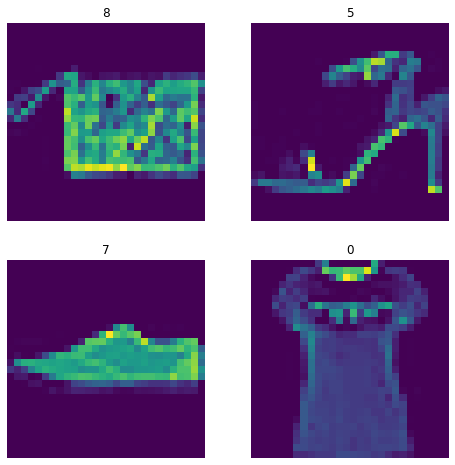

In [7]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [8]:

#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([55000, 28, 28])

In [9]:
import torch

batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [10]:
!pip install hiddenlayer

In [11]:
#-- Después de activar el entorno GPU se selecciona el dispositivo

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
#--- Definimos el modelo



model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=3),
  #out: ( (28-4+2*2)/1 ) + 1 = 28   -> 28 x 28 x20

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  #out: 28/2 = 14                 -> 14 x 14 x 20

  torch.nn.Dropout(p=0.05), 

  torch.nn.Conv2d(32, 42, kernel_size=3, stride=1, padding=2),
  #out: ( (20-6+1*2)/2 ) + 1 =    -> 9 x 9 x 15

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  #out: 9/3 = 3                 -> 3 x 3 x 42

  torch.nn.Dropout(p=0.05), 

  torch.nn.Flatten(),
  torch.nn.Linear(5*5*42, 10)
)
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.05, inplace=False)
  (4): Conv2d(32, 42, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.05, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1050, out_features=10, bias=True)
)

In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


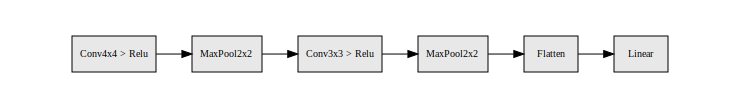

In [19]:
import hiddenlayer as hl

hl.build_graph(model, torch.zeros([32,1,28,28]))

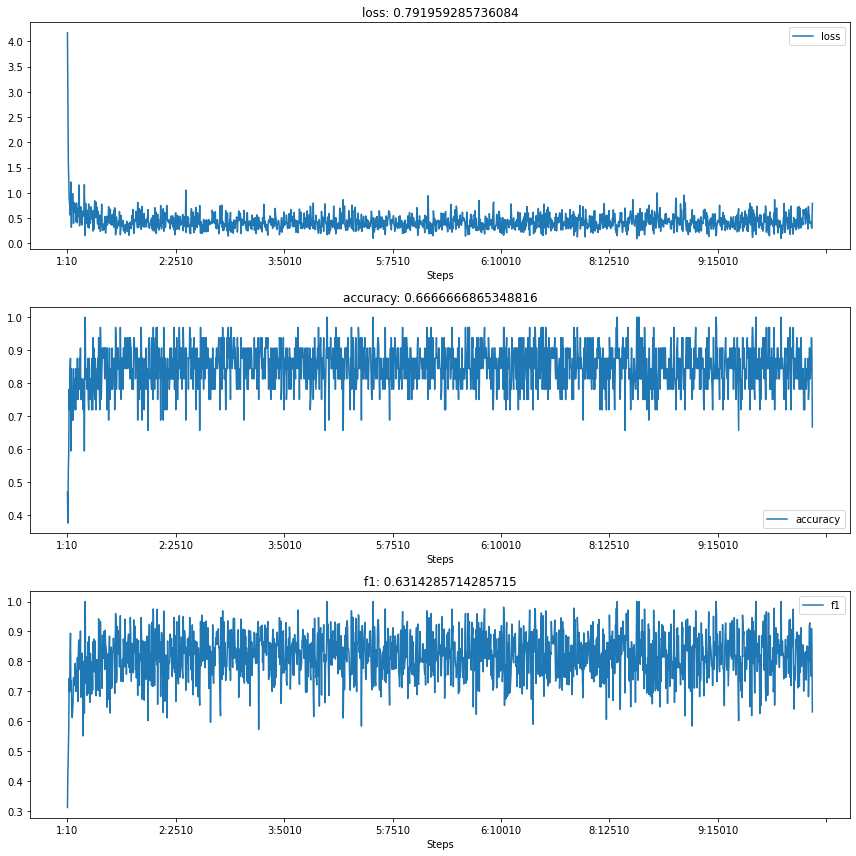

In [21]:
from sklearn.metrics import f1_score
#-- Cargamos el modelo en la GPU
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

n_epoch = 10

history2 = hl.History()
canvas2 = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):

    #-- Cargamos los datos en la GPU
    X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

    model.train()
    Xtr = X_train_batch.unsqueeze(1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    #-- Calculamos el f1 en la cpu
    f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        history2.log((epoch+1, iter), loss=loss, accuracy=acc, f1=f1)
        with canvas2:
          canvas2.draw_plot(history2["loss"])
          canvas2.draw_plot(history2["accuracy"])
          canvas2.draw_plot(history2["f1"])


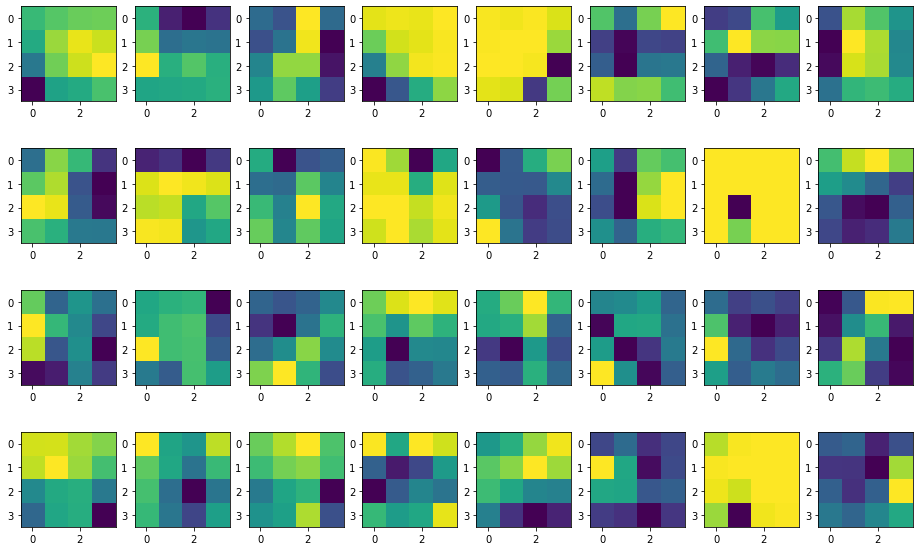

In [40]:

kernels = list(model.children())[0].weight.detach()

fig = plt.figure(figsize=(16,10))
k = 0
for i in range(kernels.size(0)):
    plt.subplot(4,8,k+1)
    plt.imshow(kernels[i].squeeze().cpu().numpy())
    k += 1
plt.show()




**conclusiones**

al evaluar el modelo se ve que nunca llega a tener un f1 satisfactorio. lo que podria estar pasando es que al utilizar un dropout muy alto o kernels muy grandes se generaliza demasiado la imagen y el modelo pierde caracteristicas importantes de cada clase, por lo que nunca llega a ser preciso en ninguna
